In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
    color: black !important;
}

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
sns.set(style="whitegrid")
sns.set_context(rc={"lines.linewidth": 2})

### 这个函数是用来统计一天的水印发放之后 每个窗口的平均等待时间和事件的迟到率

In [ ]:
def get_drop_latency(wm, latency):
    wm = pd.read_csv(wm)
    latency = pd.read_csv(latency)
    wm.columns = ["watermark", "ts"]
    
    # drop1是真正丢的数据
    drop1 = wm[-1:].iloc[0]['watermark']/wm[-1:].iloc[0]['ts']
    # drop2是默认迟到的数据
    drop2 = wm[-2:-1].iloc[0]['watermark']/wm[-2:-1].iloc[0]['ts']
    print(wm[-2:-1], drop2)
    latency.columns = ["watermark", "window_end"]
    latency = latency.set_index("watermark")
    wm = wm.set_index("watermark")
    res = latency.join(wm,  how='inner')
    res = res.reset_index(drop = True)
    
    all_wait = 0
    for index, row in res.iterrows():
        all_wait += row['ts'] - row['window_end']
        if row['ts'] - row['window_end'] > 300000:
            row['ts']  = row['window_end'] + 5000
    avg_wait = all_wait/len(res)
    print(avg_wait)
    return drop1, drop2, avg_wait, res

In [180]:
def draw_late(LatePath, threshold = 0.25):
    lateEvent = pd.read_csv(LatePath)
    lateEvent.columns = ["window_end", "late_event", "all"]
    lateEvent['rate'] = lateEvent['late_event']/lateEvent['all']

    date_index = pd.date_range(start='2018-10-01 00:01:00',
                               periods=len(lateEvent), 
                               freq='T')
    index = [date_index[i].hour for i in range(len(date_index))]
    data = {
        "late_rate": lateEvent['rate'].tolist(),
        "threshold": [threshold for _ in range(len(lateEvent))],
    }

    df = pd.DataFrame(data=data, index=index)
    f, ax = plt.subplots(figsize = (7, 3))
    ax.set_xlabel('Time',fontsize=15)
    ax.set_ylabel('DisOrder Rate',fontsize=15)
    ax.annotate('threshold=0.25', xy=(0, 0.25),
                xytext=(0, 0.43),
                arrowprops=dict(facecolor='#d0885c', headwidth=7, width=3,
                                headlength=10),
                horizontalalignment='left', verticalalignment='top')
    plt.ylim((0, 0.8))
    p = sns.lineplot(size='event', data=df)
    
    plt.show()

In [ ]:
def get_late_df(LatePaths):
    ans = []
    for LatePath in LatePaths:
        lateEvent = pd.read_csv(LatePath)
        lateEvent.columns = ["window_end", "late_event", "all"]
        lateEvent['rate'] = lateEvent['late_event']/lateEvent['all']

        date_index = pd.date_range(start='2018-10-01 00:01:00',
                                   periods=len(lateEvent), 
                                   freq='T')
        
        index = [date_index[i].hour for i in range(len(date_index))]

        data = {
            "late_rate": lateEvent['rate'].tolist(),
            "threshold": [threshold for _ in range(len(lateEvent))],
        }

        df = pd.DataFrame(data=data, index=index)
        ans.append(df)
    return ans

### 分析在周期性水印下会出现的问题(以20181001为例)

1. 在水印延迟为0ms时，窗口大小为60s
2. 在水印延迟为500ms时，窗口大小为60s
3. 在水印延迟为1000ms时，窗口大小为60s
4. 在水印延迟为2000ms时，窗口大小为60s

In [218]:
LatePaths = [
            "./periodic/20181001P0W60/disorder.csv",
            "./periodic/20181001P0.5W60/disorder.csv",
            "./periodic/20181001P1W60/disorder.csv",
#             "./periodic/20181001P1.5W60/disorder.csv",
            "./periodic/20181001P2W60/disorder.csv"
           ]
Xlabls = [
    "latency: 0ms window size: 60s",
    "latency: 500ms window size: 60s",
    "latency: 1000ms window size: 60s",
    "latency: 2000ms window size: 60s"
]

In [219]:
ans = get_late_df(LatePaths)

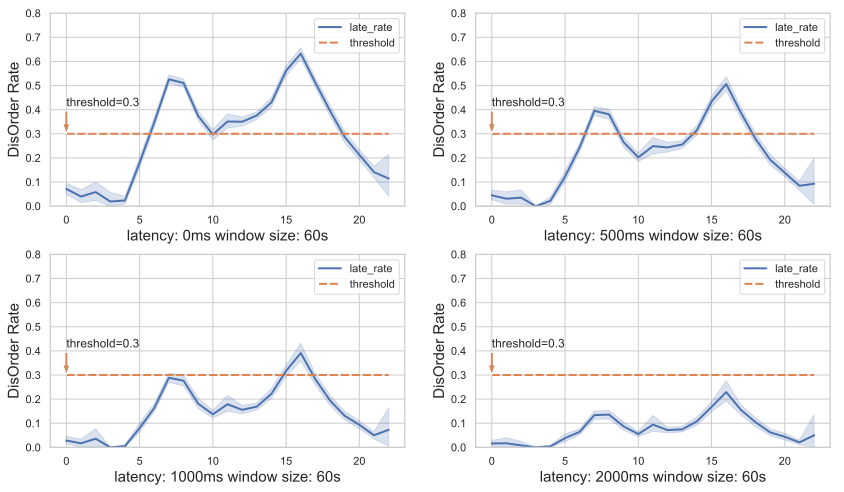

In [223]:
f, ax = plt.subplots(2,2, figsize = (14, 8))
for i in range(2):
    for j in range(2):
        ax[i][j].set_xlabel(Xlabls[i*2+j],fontsize=15)
        ax[i][j].set_ylabel('DisOrder Rate',fontsize=15)
        # 标注 指定位置添加描述
        ax[i][j].annotate('threshold=0.3', xy=(0, 0.3),
                    xytext=(0, 0.45),
                    arrowprops=dict(facecolor='#d0885c', headwidth=7, width=3,
                                    headlength=10),
                    horizontalalignment='left', verticalalignment='top')
        # 限制y轴的值
        ax[i][j].set_ylim([0, 0.8])
        sns.lineplot(size='event', data=ans[i*2+j], ax=ax[i][j])
# 设置间距
plt.subplots_adjust(wspace=0.2, hspace=0.25)